In [406]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.model_selection import learning_curve
from itertools import combinations
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

In [407]:
# Load and clean data
data = pd.read_csv('hr_pred_data.csv')
data

,player_name,year,player_age,pa,home_run,k_percent,bb_percent,isolated_power,exit_velocity_avg,launch_angle_avg,barrel_batted_rate,whiff_percent,swing_percent,flyballs_percent
0,Bartolo Colon,2017,44,20,0,50.0,0.0,0.000,78.0,-8.5,0.0,37.8,57.8,10.0
1,Adrian Beltré,2017,38,389,17,13.4,10.0,0.220,86.7,12.5,5.8,18.7,46.8,24.5
2,Carlos Beltrán,2017,40,509,14,20.0,6.5,0.152,87.3,13.4,4.6,19.8,47.9,24.3
3,Jayson Werth,2017,38,289,10,23.9,12.1,0.167,88.1,14.2,8.2,21.9,38.6,22.8
4,Bronson Arroyo,2017,40,29,0,34.5,0.0,0.000,82.4,17.0,0.0,23.8,50.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5312,Joey Wiemer Jr.,2025,26,89,0,32.1,7.1,0.000,82.8,18.0,5.9,29.8,43.1,17.6
5313,Coby Mayo,2025,23,65,0,47.8,8.7,0.000,84.7,6.0,0.0,45.6,47.9,15.8
5314,Oscar Colás,2025,26,270,0,26.3,10.5,0.000,89.9,7.1,0.0,25.3,52.1,8.7
5315,Pedro León,2025,27,45,0,47.6,4.8,0.000,93.0,16.8,20.0,42.9,46.7,10.0


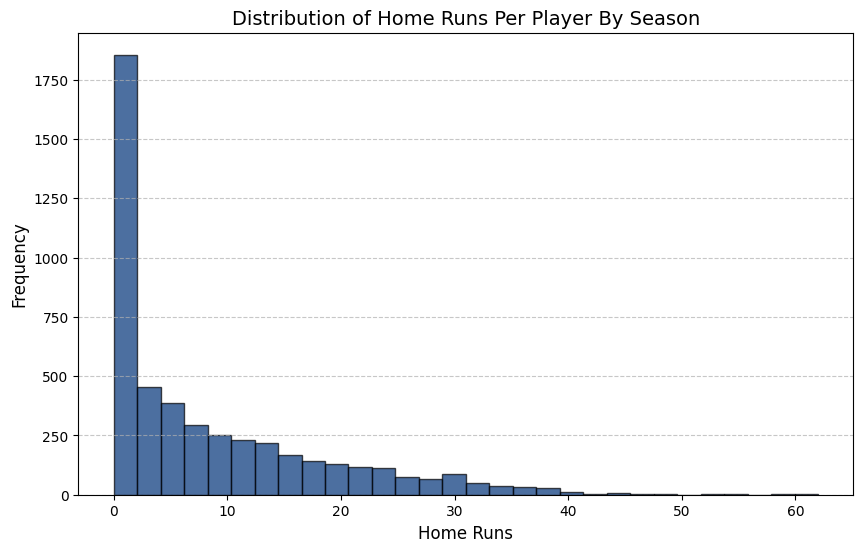

In [408]:
# Plot distribution of home runs
eda_data = data[(data['year'] <= 2024)]
plt.figure(figsize=(10, 6))
plt.hist(eda_data['home_run'], bins=30, color='#003278', edgecolor='black', alpha=0.7)
plt.title('Distribution of Home Runs Per Player By Season', fontsize=14)
plt.xlabel('Home Runs', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("HRDist.png")
plt.show()

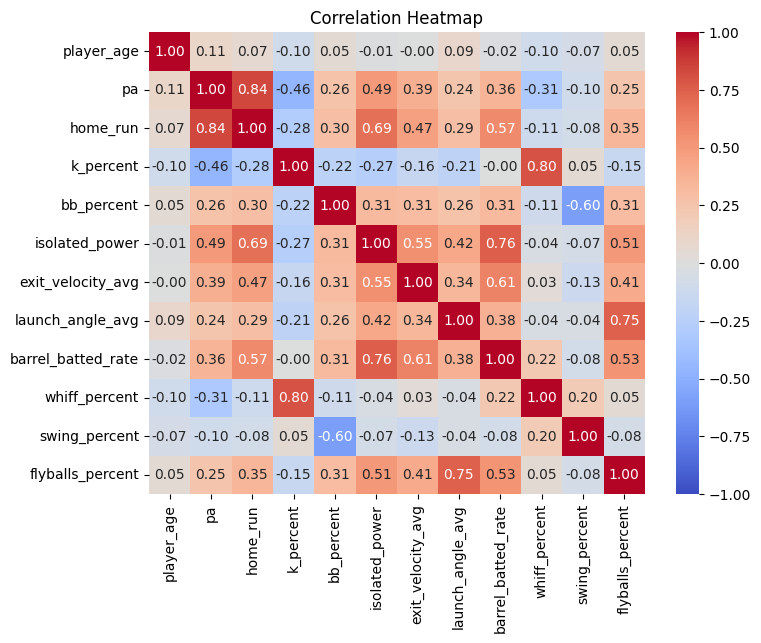

In [409]:
# Plot correlation of potential features
plt.figure(figsize=(8, 6))
corr_data = eda_data.drop(columns=['player_name', 'year'])
sns.heatmap(corr_data.corr(), annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.savefig("correlation.png")
plt.show()

In [410]:
# Initial train, validation, and test split
validation_data = data[data['year'] == 2024]
validation_metadata = validation_data[['player_name', 'year']].copy()
validation_y = validation_data['home_run']
validation_x = validation_data.drop(['home_run', 'player_name', 'year'], axis=1)
test_data = data[data['year'] == 2025]
test_metadata = test_data[['player_name', 'year']].copy()
test_y = test_data['home_run']
test_x = test_data.drop(['home_run', 'player_name', 'year'], axis=1)
train_data = data[(data['year'] <= 2023)]
train_metadata = train_data[['player_name', 'year']].copy()
train_y = train_data['home_run']
train_x = train_data.drop(['home_run', 'player_name', 'year'], axis=1)

Baseline RMSE: 1.6696924592034579


<Figure size 1000x800 with 0 Axes>

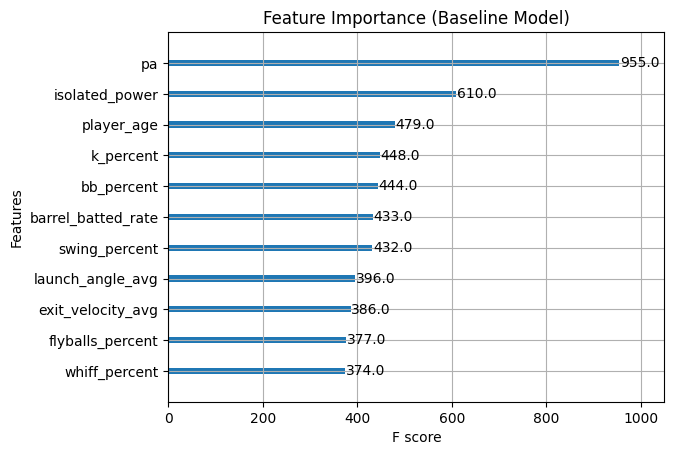

In [411]:
# Create baseline model
baseline = XGBRegressor()
baseline.fit(train_x, train_y)

importance = pd.DataFrame({
    'Feature': train_x.columns,
    'Importance': baseline.feature_importances_
}).sort_values(by='Importance', ascending=False)

y_val_pred = baseline.predict(validation_x)
rmse_val = root_mean_squared_error(validation_y, y_val_pred)

print(f"Baseline RMSE: {rmse_val}")

plt.figure(figsize=(10, 8))
plot_importance(baseline)
plt.title('Feature Importance (Baseline Model)')
plt.savefig("baseline_FI.png")
plt.show();

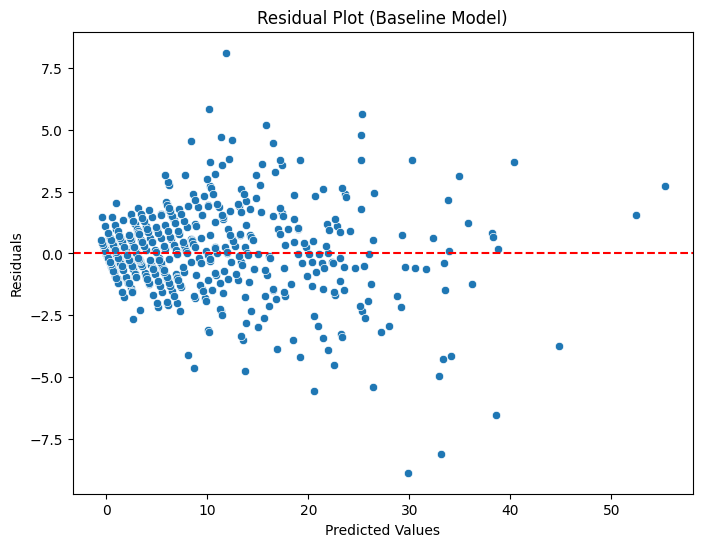

In [412]:
# Plot residuals for baseline model
baseline_residuals = validation_y - y_val_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val_pred, y=baseline_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot (Baseline Model)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.savefig("baseline_residuals.png")
plt.show()

In [413]:
# Add interaction terms and lag features
def add_rolling_average(df, column, new_column, group_column=None, window=3, min_periods=1):
    if group_column:
        df[new_column] = (
            df.groupby(group_column)[column]
            .transform(lambda x: x.rolling(window=window, min_periods=min_periods).mean().shift(1))
        )
    else:
        df[new_column] = df[column].rolling(window=window, min_periods=min_periods).mean().shift(1)
    
    return df

data = add_rolling_average(data, column='home_run', new_column='HR_3YrAvg', group_column='player_name', window=3)
data['ExitVelo_FlyBall'] = data['exit_velocity_avg'] * data['flyballs_percent']
data['BB_K'] = data['bb_percent'] * data['k_percent']
data['launch_exit_combo'] = data['launch_angle_avg'] * data['exit_velocity_avg']
data['pa_isolated_power'] = data['pa'] * data['isolated_power']

In [414]:
# Train, validation, and test split with new features
validation_data = data[data['year'] == 2024]
validation_metadata = validation_data[['player_name', 'year']].copy()
validation_y = validation_data['home_run']
validation_x = validation_data.drop(['home_run', 'player_name', 'year'], axis=1)
test_data = data[data['year'] == 2025]
test_metadata = test_data[['player_name', 'year']].copy()
test_y = test_data['home_run']
test_x = test_data.drop(['home_run', 'player_name', 'year'], axis=1)
train_data = data[(data['year'] <= 2023)]
train_metadata = train_data[['player_name', 'year']].copy()
train_y = train_data['home_run']
train_x = train_data.drop(['home_run', 'player_name', 'year'], axis=1)

In [365]:
# Generate best feature combination
def find_best_feature_combination(train_data, val_data, train_target, val_target, model, min_features=1, max_features=None):
    best_rmse = float('inf')
    best_combination = None
    best_num_features = 0

    if max_features is None:
        max_features = train_data.shape[1]

    for num_features in range(min_features, max_features + 1):
        print(f"Testing combinations with {num_features} features...")

        feature_combinations = combinations(train_data.columns, num_features)

        for combination in feature_combinations:
            train_subset = train_data[list(combination)]
            val_subset = val_data[list(combination)]

            model.fit(train_subset, train_target)

            val_predictions = model.predict(val_subset)

            rmse = np.sqrt(mean_squared_error(val_target, val_predictions))

            if rmse < best_rmse:
                best_rmse = rmse
                best_combination = combination
                best_num_features = num_features

    return {
        'best_rmse': best_rmse,
        'best_combination': best_combination,
        'num_features': best_num_features
    }

model = XGBRegressor()
result = find_best_feature_combination(train_x, validation_x, train_y, validation_y, model, min_features=12, max_features=17)

print("Best RMSE:", result['best_rmse'])
print("Best Feature Combination:", result['best_combination'])
print("Number of Features:", result['num_features'])

Testing combinations with 12 features...
Testing combinations with 13 features...
Testing combinations with 14 features...
Testing combinations with 15 features...
Testing combinations with 16 features...
Testing combinations with 17 features...
Best RMSE: 1.5997719365377774
Best Feature Combination: ('pa', 'k_percent', 'bb_percent', 'isolated_power', 'exit_velocity_avg', 'launch_angle_avg', 'whiff_percent', 'swing_percent', 'flyballs_percent', 'HR_3YrAvg', 'ExitVelo_FlyBall', 'BB_K', 'launch_exit_combo')
Number of Features: 13


Post FE RMSE: 1.5997719365377774


<Figure size 1000x800 with 0 Axes>

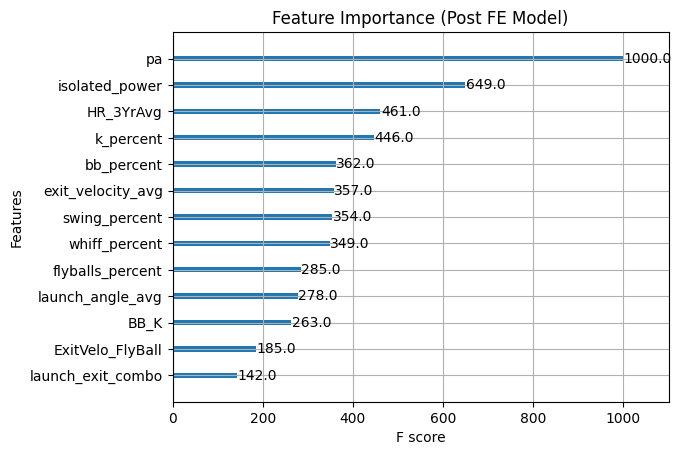

In [415]:
# Create model with relevant interaction terms
top_features = ['pa', 'k_percent', 'bb_percent', 'isolated_power', 'exit_velocity_avg', 'launch_angle_avg', 'whiff_percent', 'swing_percent', 'flyballs_percent', 'HR_3YrAvg', 'ExitVelo_FlyBall', 'BB_K', 'launch_exit_combo']

train_x_postfe = train_x[top_features]
validation_x_postfe = validation_x[top_features]

postfe = XGBRegressor()
postfe.fit(train_x_postfe, train_y)

importance_postfe = pd.DataFrame({
    'Feature': train_x_postfe.columns,
    'Importance': postfe.feature_importances_
}).sort_values(by='Importance', ascending=False)

y_val_pred_postfe = postfe.predict(validation_x_postfe)
rmse_val_postfe = root_mean_squared_error(validation_y, y_val_pred_postfe)

print(f"Post FE RMSE: {rmse_val_postfe}")

plt.figure(figsize=(10, 8))
plot_importance(postfe)
plt.title('Feature Importance (Post FE Model)')
plt.savefig("postFE_FI.png")
plt.show()

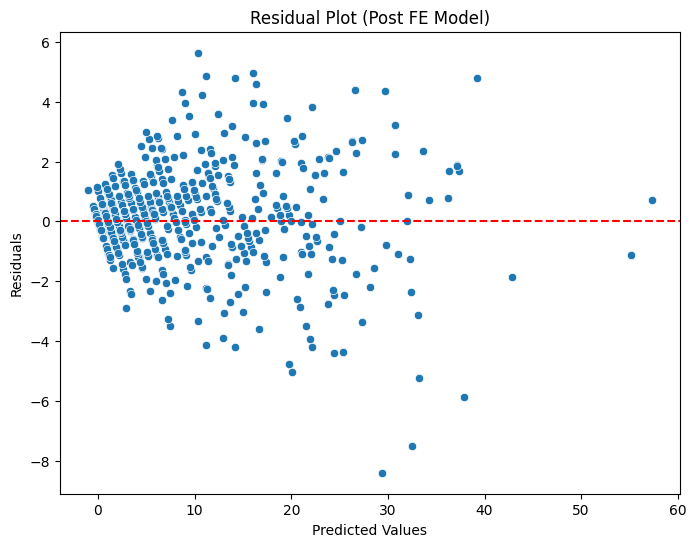

In [416]:
# Plot residuals for Post FE model
postfe_residuals = validation_y - y_val_pred_postfe

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val_pred_postfe, y=postfe_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot (Post FE Model)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.savefig("postFE_residuals.png")
plt.show()

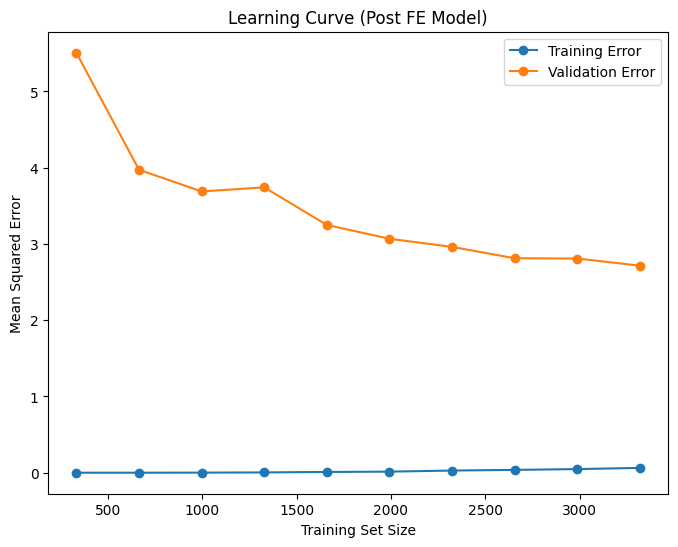

In [417]:
# Plot learning curve for post-FE model
train_sizes, train_scores, test_scores = learning_curve(
    postfe, train_x_postfe, train_y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = -np.mean(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training Error', marker='o')
plt.plot(train_sizes, test_mean, label='Validation Error', marker='o')
plt.title('Learning Curve (Post FE Model)')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.savefig("postFE_LC.png")
plt.show()

In [369]:
# Hyperparameter Tuning
def grid_search_hyperparameters(X_train, y_train, X_val, y_val, param_grid):
    results = []
    best_params = None
    best_rmse = float('inf')

    for params in ParameterGrid(param_grid):
        model = XGBRegressor(
            max_depth=params['max_depth'],
            min_child_weight=params['min_child_weight'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            learning_rate=params['learning_rate'],
            n_estimators=params['n_estimators'],
            reg_alpha=params['reg_alpha'],
            reg_lambda=params['reg_lambda']
        )

        model.fit(X_train, y_train)

        y_val_pred = model.predict(X_val)

        rmse = np.sqrt(np.mean((y_val - y_val_pred) ** 2))
        results.append((params, rmse))

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params

    return {
        "best_params": best_params,
        "best_rmse": best_rmse,
        "results": results
    }

param_grid = {
    'max_depth': [3, 4],
    'min_child_weight': [3, 5],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.8, 1.0],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [200, 300],
    'reg_alpha': [0.5, 1],
    'reg_lambda': [0.5, 1]
}

results = grid_search_hyperparameters(train_x_postfe, train_y, validation_x_postfe, validation_y, param_grid)

print(f"Best hyperparameters: {results['best_params']}")
print(f"Lowest validation RMSE: {results['best_rmse']}")

Best hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 0.5, 'subsample': 0.6}
Lowest validation RMSE: 1.5342844502366293


Validation RMSE: 1.5342844502366293


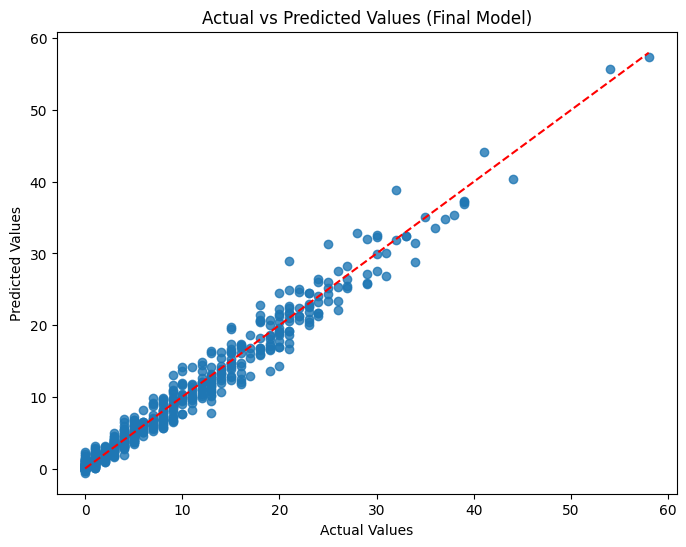

In [418]:
#Validate hyperparameters
best_model = XGBRegressor(
        colsample_bytree = 1.0,
        learning_rate= 0.05,
        max_depth= 4,
        min_child_weight = 3,
        n_estimators= 200,
        reg_alpha = 1,
        reg_lambda = 0.5,
        subsample = 0.6

    )

best_model.fit(train_x_postfe, train_y)
y_val_pred_final = best_model.predict(validation_x_postfe)

val_rmse_final = root_mean_squared_error(validation_y, y_val_pred_final)
print(f"Validation RMSE: {val_rmse_final}")

plt.figure(figsize=(8, 6))
plt.scatter(validation_y, y_val_pred_final, alpha=0.8)
plt.plot([validation_y.min(), validation_y.max()], [validation_y.min(), validation_y.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values (Final Model)")
plt.savefig("final_actual_pred.png")
plt.show()

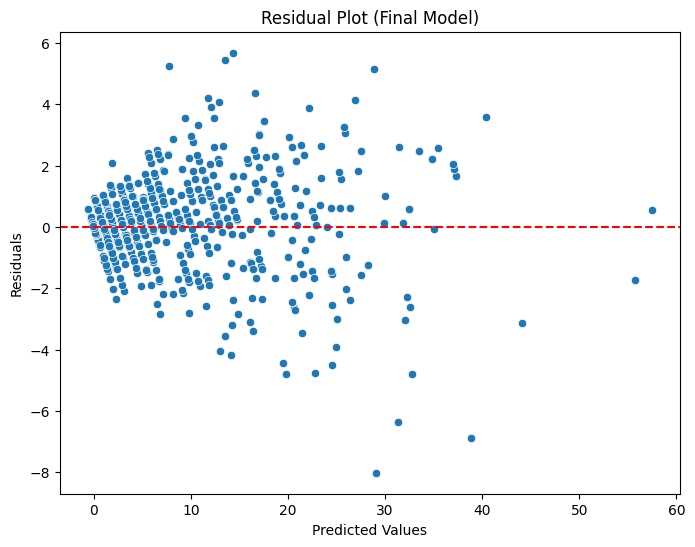

In [419]:
# Plot residuals for final model
final_residuals = validation_y - y_val_pred_final

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val_pred_final, y=final_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot (Final Model)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.savefig("final_residuals.png")
plt.show()

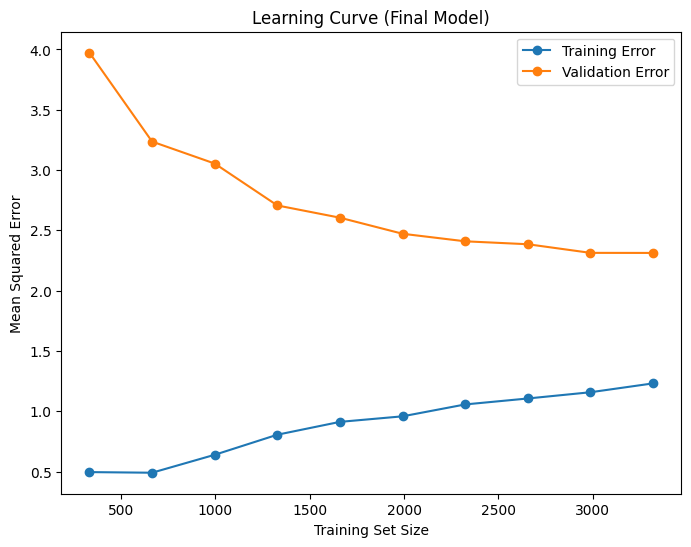

In [392]:
# Plot learning curve of final model
train_sizes, train_scores, test_scores = learning_curve(
    best_model, train_x_postfe, train_y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = -np.mean(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training Error', marker='o')
plt.plot(train_sizes, test_mean, label='Validation Error', marker='o')
plt.title('Learning Curve (Final Model)')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.savefig("final_LC.png")
plt.show()

In [420]:
# Regress test data to the mean and generate predictions
regress_columns = ['k_percent', 'bb_percent', 'isolated_power', 'exit_velocity_avg', 'launch_angle_avg', 'whiff_percent', 'swing_percent', 'flyballs_percent', 'ExitVelo_FlyBall', 'BB_K', 'launch_exit_combo']

scaling_factor = 1
means = test_x[regress_columns].mean()

def regress_to_mean(column, mean_value, scaling_factor):
    alpha = scaling_factor * abs(column - mean_value)
    alpha = alpha.clip(upper=1) 
    return alpha * mean_value + (1 - alpha) * column

for col in regress_columns:
    test_x[col] = regress_to_mean(test_x[col], means[col], scaling_factor)

test_x_final = test_x[top_features]

best_model.fit(train_x_postfe, train_y)
y_test_pred = best_model.predict(test_x_final)

test_results = test_metadata[['player_name']].copy()
test_results['predicted_home_runs'] = y_test_pred.round().astype(int)
test_results_sorted = test_results.sort_values(by='predicted_home_runs', ascending=False)

test_results_sorted[['player_name', 'predicted_home_runs']].to_csv(
    'hr_predictions.csv', 
    index=False, 
    encoding='utf-8-sig'
)
print("'CSV file saved as 'hr_predictions.csv'")

'CSV file saved as 'hr_predictions.csv'


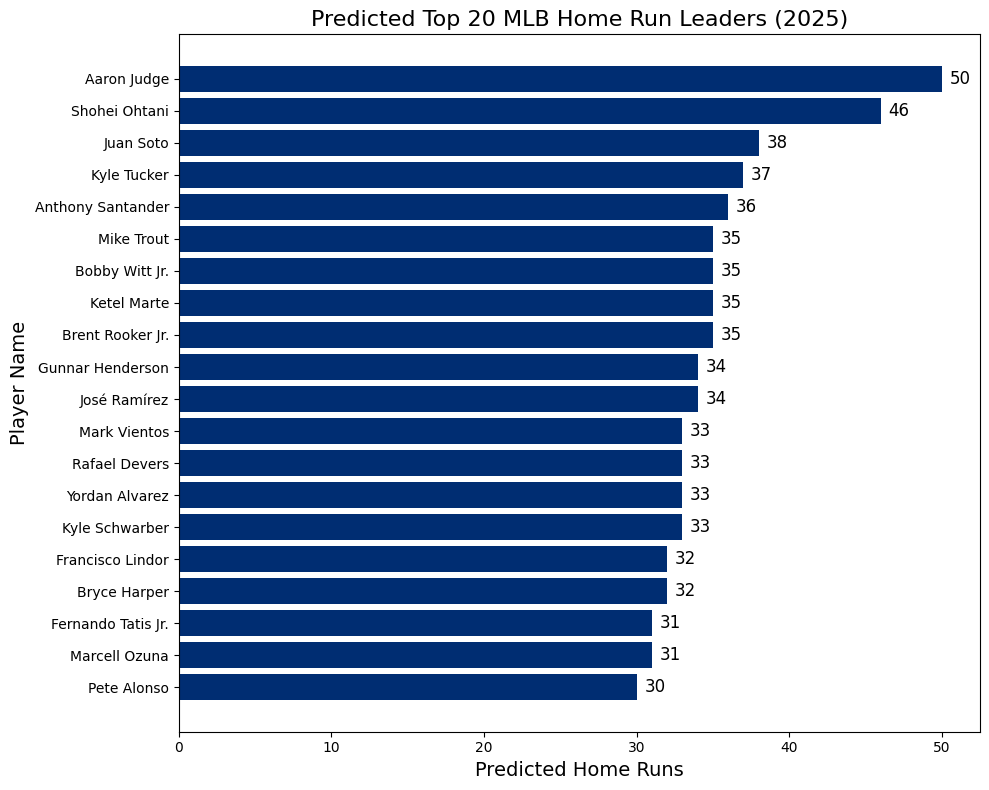

In [395]:
# Plot the top 20 projected HR leaders
top_15 = test_results_sorted.head(20)

plt.figure(figsize=(10, 8))
bars = plt.barh(top_15['player_name'], top_15['predicted_home_runs'], color='#002D72')
plt.gca().invert_yaxis() 
plt.title('Predicted Top 20 MLB Home Run Leaders (2025)', fontsize=16)
plt.xlabel('Predicted Home Runs', fontsize=14)
plt.ylabel('Player Name', fontsize=14)

for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.5, 
        bar.get_y() + bar.get_height() / 2,  
        f'{int(width)}',  
        va='center', fontsize=12  
    )

plt.tight_layout()
plt.savefig("hr_leaderboard.png")
plt.show()